In [1]:
# find best features for multi-lable classification modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score

In [2]:
import os
os.getcwd()

'D:\\python3\\Scripts'

In [3]:
os.chdir('D:/project/gatsby')

In [59]:
# set the seed and load the data
np.random.seed(111)
data = pd.read_csv('data/feature_document_matrix_21.csv')
X = data.drop(data.columns[[0,1]], axis=1)
y = data.id

In [60]:
# calculate the performance of SVM-anova classifer
clf = Pipeline(
    [
        ("anova", SelectKBest(f_classif)),
        ("scaler", StandardScaler()),
        ("svc", LinearSVC(dual="auto")),
    ]
)

score_means = list()
score_stds = list()
nfs = range(1, len(X.columns)+1)

for n in nfs:
    clf.set_params(anova__k=n)
    this_scores = cross_val_score(clf, X, y, cv = ms.StratifiedKFold(shuffle = True))
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

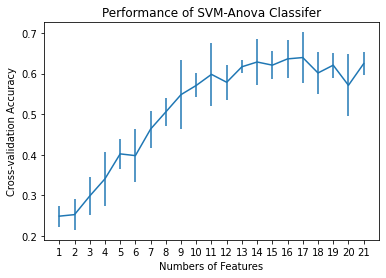

In [61]:
# plot the performance of SVM-anova classifer
plt.errorbar(nfs, score_means, np.array(score_stds))
plt.title("Performance of SVM-Anova Classifer")
plt.xticks(nfs)
plt.xlabel("Numbers of Features")
plt.ylabel("Cross-validation Accuracy")
plt.axis("tight")
plt.show()

In [62]:
# calculate the precision, recall and f1-score of features
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

In [73]:
# define feature selection
fs = SelectKBest(score_func=f_classif, k=17)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)
anova_filter = fs
clf = LinearSVC(dual="auto")
anova_svm = make_pipeline(anova_filter, clf)
anova_svm.fit(X, y)
y_pred = anova_svm.predict(X)
labels = ['kao','wu','yao','wang','lijh','deng','chang','su','lijc']
print(classification_report(y, y_pred, labels=labels))

(261, 17)
              precision    recall  f1-score   support

         kao       0.92      0.79      0.85        29
          wu       0.62      0.72      0.67        29
         yao       0.56      0.34      0.43        29
        wang       0.96      0.93      0.95        29
        lijh       0.77      0.79      0.78        29
        deng       0.58      0.52      0.55        29
       chang       0.84      0.90      0.87        29
          su       0.75      0.93      0.83        29
        lijc       0.82      0.93      0.87        29

    accuracy                           0.76       261
   macro avg       0.76      0.76      0.75       261
weighted avg       0.76      0.76      0.75       261



In [77]:
# getting Fisher's Scores for all features
def get_numerical_features(features, class_label):
    #class_label is already a Dataframe in your data demo
    fs=SelectKBest(f_classif, k='all')
    fs.fit(features, class_label)
    scores = pd.DataFrame({'feature': X.columns, 'score': fs.scores_})
    scores = scores.sort_values(by='score', ascending=False)
    print(scores)

    #for i, feature in zip(range(len(features)), features): 
        #print('Feature %s: %f' % (feature, fs.scores_[i]))

# applying the function
get_numerical_features(features=X, class_label=y)

   feature      score
10     con  55.608979
0     kttr  19.218895
16     asl  13.992783
9       ad  13.868385
5      mwr  11.113572
3       cw  10.370561
4      idm  10.212717
20     bei   9.961437
18     mdd   8.834549
12      pp   8.824643
19      ba   8.705364
7       vv   4.542874
2       rw   4.367783
17     pun   4.007712
6       nn   3.976624
13      pn   3.717699
11      cc   3.170075
8       jj   2.432026
15     v2j   2.098943
14     n2v   1.998169
1    hapax   1.068151


In [14]:
# calculate accuracy scores for all pairs
df = pd.read_csv('data/feature_document_matrix_17.csv')
labels = ['kao','wu','yao','wang','lijh','deng','chang','su','lijc'][::-1]
fs = SelectKBest(score_func=f_classif, k='all')
clf = LinearSVC(dual="auto")
ascore = []
for i in range(8):
    for j in range(1, 9):
        if i>=j: continue
        data = df.loc[(df['id'] == labels[i])|(df['id'] == labels[j])]
        X = data.drop(data.columns[[0,1]], axis=1)
        y = data.id
        anova_svm = make_pipeline(fs, clf)
        anova_svm.fit(X, y)
        y_pred = anova_svm.predict(X)
        acs = accuracy_score(y, y_pred)
        pa = (labels[i], labels[j], acs)
        ascore.append(pa)
df_ascore = pd.DataFrame(ascore)
df_ascore.columns = ['V1', 'V2', 'Accuracy']
df_ascore.to_csv('results/pair-wise_accuracy_scores.csv', sep=',', index=False)

In [15]:
# transform the data into a table
df=df_ascore
df.V1=pd.Categorical(df.V1, categories=df.V1.unique()[::-1], ordered=True)
df.V2=pd.Categorical(df.V2, categories=df.V2.unique(), ordered=True)
tab = df.pivot_table(index='V1', columns='V2', values='Accuracy', sort=False).rename_axis(index=None, columns=None)#.T
tab = tab.iloc[::-1, ::-1]
tab.to_csv('results/pair-wise_accuracy_scores_trans.csv', sep=',', index=True)